# First make sure all the files are ready for analysis

In [11]:
import sys
sys.path.append('/home/itskov/Dropbox/workspace/lab/DeepSemantic/WormSegmentation')
%config IPCompleter.greedy=True

import matplotlib
#matplotlib.use('TkAgg')

from glob2 import glob
from Behavior.General.ExpDir import ExpDir
from Behavior.General.Experiment import Experiment
from os import listdir, path
import pandas as pd


# Debug (Temporary)
from Behavior.General import Track
sys.modules['Track'] = Track
# Debug (Temporary)

import numpy as np
import re

print('Starting..')

# Here is where the tracked files are stored.
#rootDir = '/mnt/storageNASRe/tph1/Results/24-Nov-2019'
#rootDir = '/mnt/storageNASRe/ChristianData/ChrisNewTracks/'
rootDir = '/mnt/storageNASRe/tph1/Results/27-Feb-2020/'
allTrackedFiles = glob(rootDir + '/**/*tracks.npy')
allTrackedDirectories = [path.dirname(tracksFile) for tracksFile in allTrackedFiles]


# Here we store our experiments meta information
expDf = pd.DataFrame(columns=['date','time', 'cond','fullFile'])

for i, trackedDir in enumerate(allTrackedDirectories):
    fullFile = path.join(rootDir, trackedDir)
    print("%d. Going over %s" % (i, fullFile))
    
    # This object helps us manage the tracked files.
    expDir = ExpDir(str(fullFile))
    
    #if True:
    if (expDir.getExpFile() == None) or (not expDir.isValid()):
        #newExp = Experiment(expDir.getVidFile(), np.load(expDir.getTracksFile()))
        newExp = Experiment(expDir)
        newExp.takeScale()
        newExp.addCirclePotisionRad('startReg',newExp._scale / 5)
        newExp.addCirclePotisionRad('endReg',newExp._scale / 4)
        newExp.save()
        pass
     
    print(fullFile)
    currentDate = re.search('\d\d-\w\w\w-\d\d\d\d',trackedDir)[0]
    currentTime = re.search('_(\d\d\.\d\d\.\d\d)',path.basename(fullFile))[1]
    cond = re.search('(.*)\.avi',path.basename(fullFile))[1]
    
    # Irregularities
    #if cond == 'STAP_Mock':
    #    cond = 'MOCK_STAP'
    #elif cond == 'LTAV_MOCK':
    #    cond = 'MOCK_LTAV'
    #elif cond == 'TEMP_EYAL_LIGHT':
    #    continue
    
    expDf.loc[i] = [currentDate, currentTime, cond, fullFile]
    #print('Date: ' + currentDate + ' Cond: ' + cond)
expDf

Starting..
0. Going over /mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_0D.avi_11.49.56
/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_0D.avi_11.49.56
1. Going over /mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_0D.avi_14.20.27
/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_0D.avi_14.20.27
2. Going over /mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_D0.avi_10.35.08
/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_D0.avi_10.35.08
3. Going over /mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_D0.avi_13.05.28
/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_D0.avi_13.05.28
4. Going over /mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_NO_ATR_TRAIN_75M_0D.avi_10.33.43
/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_NO_ATR_TRAIN_75M_0D.avi_10.33.43
5. Going over /mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_NO_ATR_TRAIN_75M_0D.avi_13.04.39
/mnt/storageNASRe/tph1/Resu

,date,time,cond,fullFile
0,27-Feb-2020,11.49.56,TPH_1_ATR_TRAIN_75M_0D,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
1,27-Feb-2020,14.20.27,TPH_1_ATR_TRAIN_75M_0D,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
2,27-Feb-2020,10.35.08,TPH_1_ATR_TRAIN_75M_D0,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
3,27-Feb-2020,13.05.28,TPH_1_ATR_TRAIN_75M_D0,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
4,27-Feb-2020,10.33.43,TPH_1_NO_ATR_TRAIN_75M_0D,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
5,27-Feb-2020,13.04.39,TPH_1_NO_ATR_TRAIN_75M_0D,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
6,27-Feb-2020,11.48.58,TPH_1_NO_ATR_TRAIN_75M_D0,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...
7,27-Feb-2020,14.19.35,TPH_1_NO_ATR_TRAIN_75M_D0,/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH...



# Pair analyses

In [2]:
import sys
import pandas as pd
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, VBox,HBox

from Behavior.Visualizers.PairwiseAnalyses import PairWiseRoi
#from Behavior.Visualizers.JointSpeedProjection import JointSpeedProjection
from Behavior.Visualizers.PairwiseAnalyses import PairWiseProjectionDensity, PairWiseOccupVisoulatizer, PairWiseSpeedDensity, PairWiseJointSpeedProjection
from Behavior.General.TracksFilter import filterTracksForAnalyses



# First experiment widgets
#print(pd.unique(expDf['date']))
dateWidget1 = widgets.Dropdown(options=pd.unique(expDf['date']),value=expDf['date'][0], description='Date')
condWidget1 = widgets.Dropdown(options=pd.unique(expDf['cond']),value=expDf['cond'][0], description='Cond')
timeWidget1 = widgets.Dropdown(options=[], description='Time')

# Second experiment widgets
dateWidget2 = widgets.Dropdown(options=pd.unique(expDf['date']),value=expDf['date'][0], description='Date')
condWidget2 = widgets.Dropdown(options=pd.unique(expDf['cond']),value=expDf['cond'][0], description='Cond')
timeWidget2 = widgets.Dropdown(options=[], description='Time')

out = widgets.Output()
display(out)

@out.capture()
def runAnalysis(arg):
    firstCond = condWidget1.value
    firstDate = dateWidget1.value
    firstTime = timeWidget1.value
    secondCond = condWidget2.value
    secondDate = dateWidget2.value
    secondTime = timeWidget2.value
    
    firstFile = expDf[(expDf.cond == firstCond) & 
                      (expDf.date == firstDate) & 
                      (expDf.time == firstTime)]['fullFile']
    
    secondFile = expDf[(expDf.cond == secondCond) & 
                       (expDf.date == secondDate) & 
                       (expDf.time == secondTime)]['fullFile']
    
    firstFile = path.join(firstFile.values[0],'exp.npy')
    secondFile = path.join(secondFile.values[0],'exp.npy')
    
    print(firstFile)
    print(secondFile)
    firstExp = np.load(firstFile)[0]
    secondExp = np.load(secondFile)[0]
    
    # Shortenning the experiments.
    firstExp.trimExperiment(4500)
    secondExp.trimExperiment(4500)
        
    print('Filtering tracks for anaylses..')
    #firstExp._tracks = filterTracksForAnalyses(firstExp._tracks)
    #secondExp._tracks = filterTracksForAnalyses(secondExp._tracks)

    PairWiseRoi(firstCond, firstExp, secondCond, secondExp)
    PairWiseProjectionDensity(firstCond, firstExp, secondCond, secondExp)
    PairWiseSpeedDensity(firstCond, firstExp, secondCond, secondExp)
    PairWiseOccupVisoulatizer(firstCond, firstExp, secondCond, secondExp)
    PairWiseJointSpeedProjection(firstCond, firstExp, secondCond, secondExp)
    #PairWiseRevDistances(firstCond, firstExp, secondCond, secondExp)
    

# Run button
runButton = widgets.Button(description="Run")
runButton.on_click(runAnalysis)

def on_cond_value_change1(*change):        
    dateWidget1.options = pd.unique(expDf[expDf['cond'] == condWidget1.value]['date'])
    timeWidget1.options = pd.unique(expDf[expDf['cond'] == condWidget1.value]['time'])
    
def on_date_value_change1(*change):
    timeWidget1.options = expDf[(expDf['cond'] == condWidget1.value) & (expDf['date'] == dateWidget1.value) ]['time']
    
def on_cond_value_change2(*change):        
    dateWidget2.options = pd.unique(expDf[expDf['cond'] == condWidget2.value]['date'])
    timeWidget2.options = pd.unique(expDf[expDf['cond'] == condWidget2.value]['time'])

def on_date_value_change2(*change):
    timeWidget2.options = expDf[(expDf['cond'] == condWidget2.value) & (expDf['date'] == dateWidget2.value) ]['time']

condWidget1.observe(on_cond_value_change1, names='value')
dateWidget1.observe(on_date_value_change1, names='value')
condWidget2.observe(on_cond_value_change2, names='value')
dateWidget2.observe(on_date_value_change2, names='value')

# Display layout
HBox([VBox([condWidget1, dateWidget1, timeWidget1]), VBox([condWidget2, dateWidget2, timeWidget2]), runButton])

/home/itskov/Dropbox/workspace/homework/NeuralNetworks/venv/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/itskov/Dropbox/workspace/homework/NeuralNetworks/venv/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


Output()

# Create Pair Movie


Reinitializing.
Reinitializing.
Trimming Experiment to 4500 frames.
Trimming Experiment to 4500 frames.
Allocating space.
Filtering tracks. Before: 2721, After: 2721
Allocating space.
Filtering tracks. Before: 1785, After: 1785
Processed Frame 4498 / 4500[None]


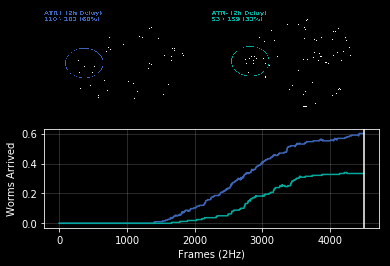

In [6]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


from Behavior.General.ExpPair import ExpPair
from Behavior.General.TracksFilter import filterTracksForAnalyses

#expPair = ExpPair('/home/itskov/Temp/behav/12-Dec-2019/STAP_CHOICETEST.avi_13.05.52/exp.npy', 
#                  '/home/itskov/Temp/behav/12-Dec-2019/STAP_MOCK_CHOICETEST.avi_13.06.49/exp.npy')

#expPair._firstExp.trimExperiment(5501)
#expPair._secondExp.trimExperiment(5501)

#expPair.createPairVisualization(4500, dpi=250)

# Presentation video.
#expPair1 = ('/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_ATR_TRAIN_75M_0D.avi_14.20.27/exp.npy', 
#            '/mnt/storageNASRe/tph1/Results/27-Feb-2020/TPH_1_NO_ATR_TRAIN_75M_D0.avi_14.19.35/exp.npy')


expPair1 = ('/mnt/storageNASRe/tph1/Results/22-Jan-2020/TPH_1_ATR_TRAIN_65M_D120_NO_IAA3x5.avi_12.57.03/exp.npy', 
            '/mnt/storageNASRe/tph1/Results/22-Jan-2020/TPH_1_NO_ATR_TRAIN_65M_D120_NO_IAA3x5.avi_12.56.12/exp.npy')



def func(expPairNames):
    expPair = ExpPair(expPairNames[0], expPairNames[1], cond1='ATR+ (2h Delay)',cond2='ATR- (2h Delay)')
    expPair._firstExp.trimExperiment(4500)
    expPair._secondExp.trimExperiment(4500)
    
    #DEBUG
    expPair._firstExp._tracks = filterTracksForAnalyses(expPair._firstExp._tracks, minSteps=20, minDistance=50)
    expPair._secondExp._tracks = filterTracksForAnalyses(expPair._secondExp._tracks, minSteps=20,  minDistance=50)
    #DEBUG

    expPair.createPairVisualization(4500, dpi=250)
    
from multiprocessing import Pool

p = Pool(1)
print(list(map(func,[expPair1])))


# Create ROI Artifact

In [ ]:
import sys
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')


from pathlib import Path
from os import path
from Behavior.Tools.Artifacts import Artifacts
from Behavior.Visualiz

import numpy as np

rootDir = '/mnt/storageNASRe/tph1/Results/19-Nov-2019/'

for fileName in Path(rootDir).rglob('exp.npy'):
    print(fileName)
            
    # load experiment.
    exp = np.load(fileName)[0]
    
    # Create an artifact folder.
    art = Artifacts(exp)
    
    exp
    
    
        
    

# Re-Initialize Experiemnt in a new Location

In [12]:
%config IPCompleter.greedy=True

import sys
import os
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')

import numpy as np

from os import path
from Behavior.General.ExpDir import ExpDir
from glob import glob

from Behavior.Tools.Artifacts import Artifacts
from Behavior.Visualizers.RoiAnalysis import RoiAnalysis
from Behavior.Visualizers.ProjectionAnalyses import ProjectionAnalyses
from Behavior.Visualizers.SpeedsAnalyses import SpeedsAnalyses
from Behavior.Visualizers.OccupVisualizer import OccupVisualizer

'''expFile = '/home/itskov/Temp/behav/28-Nov-2019/TPH_1_NO_ATR_TRAIN_NO_IAA3x5.avi_17.13.10/exp.npy'
currentExp = np.load(expFile)[0]
expDir = currentExp.initialize(ExpDir(path.dirname(expFile)))
print('Saving..')
currentExp.save()'''


DIR = '/mnt/storageNASRe/tph1/Results/'

globPath = DIR + '/**/**/exp.npy'
print(globPath)
expFiles = glob(globPath)

print(expFiles)

for i,expFile in enumerate(expFiles):
    try:
        print("%d. Going over %s" %  (i, expFile,))
        currentExp = np.load(expFile)[0]
        
        
        expDir = currentExp.initialize(ExpDir(path.dirname(expFile)))        
        art = Artifacts(expLocation=path.dirname(expFile))
        art.checkForArtifactsDir()
        
        #roiAnalyses = RoiAnalysis(currentExp)
        projectionAnalyses = ProjectionAnalyses(currentExp)
        #occupAnalyses = OccupVisualizer(currentExp)
        #speedsAnalyses = SpeedsAnalyses(currentExp)
        
        #roiAnalyses.execute()
        projectionAnalyses.execute()
        #occupAnalyses.execute(showPlot = False)
        #speedsAnalyses.execute()
        
        #art.addArtifact('roi', roiAnalyses._results)
        art.addArtifact('proj', projectionAnalyses._results)
        #art.addArtifact('occup', occupAnalyses._results)
        #art.addArtifact('speed', speedsAnalyses._results)

        
         
        print('Saving..')
        currentExp.save()
        print('Done.')
        os.system('clear')
    except Exception as ex:
        print('Error with %s: %s' % (expFile,str(ex)))

    
    

/mnt/storageNASRe/tph1/Results//**/**/exp.npy
['/mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_ATR_TRAIN_IAA3.avi_19.26.30/exp.npy', '/mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_ATR_TRAIN_IAA3.avi_12.14.20/exp.npy', '/mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_NO_ATR_TRAIN_IAA3.avi_12.13.37/exp.npy', '/mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_NO_ATR_TRAIN_IAA3.avi_16.35.58/exp.npy', '/mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_ATR_TRAIN_IAA3.avi_16.35.13/exp.npy', '/mnt/storageNASRe/tph1/Results/12-Sep-2019/TPH_1_NO_ATR_TRAIN_IAA3.avi_19.25.48/exp.npy', '/mnt/storageNASRe/tph1/Results/11-Sep-2019/TPH_1_NO_ATR_TRAIN_NO_IAA3.avi_12.57.02/exp.npy', '/mnt/storageNASRe/tph1/Results/11-Sep-2019/TPH_1_ATR_TRAIN_NO_IAA3.avi_12.58.44/exp.npy', '/mnt/storageNASRe/tph1/Results/05-Sep-2019/TPH_1_NO_ATR_TRAIN_IAA3.avi_12.21.36/exp.npy', '/mnt/storageNASRe/tph1/Results/05-Sep-2019/TPH_1_NO_ATR_TRAIN_IAA3.avi_14.47.22/exp.npy', '/mnt/storageNASRe/tph1/Results/05-Sep-2019/TPH_1

KeyboardInterrupt: 

# Christian Initialization


In [ ]:
%config IPCompleter.greedy=True

import sys
import os
sys.path.append('/home/itskov/workspace/lab/DeepSemantic/WormSegmentation')

import numpy as np

from os import path
from Behavior.General.ExpDir import ExpDir
from glob import glob

from Behavior.Tools.Artifacts import Artifacts
from Behavior.Visualizers.RoiAnalysis import RoiAnalysis
from Behavior.Visualizers.ProjectionAnalyses import ProjectionAnalyses
from Behavior.Visualizers.OccupVisualizer import OccupVisualizer

'''expFile = '/home/itskov/Temp/behav/28-Nov-2019/TPH_1_NO_ATR_TRAIN_NO_IAA3x5.avi_17.13.10/exp.npy'
currentExp = np.load(expFile)[0]
expDir = currentExp.initialize(ExpDir(path.dirname(expFile)))
print('Saving..')
currentExp.save()'''


DIR = '/home/itskov/Temp/Chris/'

globPath = DIR + '/**/**/exp.npy'
print(globPath)
expFiles = glob(globPath)

print(expFiles)

for i,expFile in enumerate(expFiles):
    try:
        print("%d. Going over %s" %  (i, expFile,))
        currentExp = np.load(expFile)[0]
        
        
        expDir = currentExp.initialize(ExpDir(path.dirname(expFile)))
        #DEBUG CHRISTIAN          
        currentExp._regionsOfInterest['startReg']['rad'] = currentExp._scale / 2
        currentExp._regionsOfInterest['endReg']['rad'] = currentExp._scale / 4
        currentExp.trimExperiment(4500)
        #DEBUG CHRISTIAN
        
        art = Artifacts(expLocation=path.dirname(expFile))
        art.checkForArtifactsDir()
        
        roiAnalyses = RoiAnalysis(currentExp)
        #projectionAnalyses = ProjectionAnalyses(currentExp)
        #occupAnalyses = OccupVisualizer(currentExp)
        
        roiAnalyses.execute()
        #projectionAnalyses.execute()
        #occupAnalyses.execute(showPlot = False)
        
        art.addArtifact('roi_2', roiAnalyses._results)
        #art.addArtifact('proj', projectionAnalyses._results)
        #art.addArtifact('occup', occupAnalyses._results)

        
         
        #print('Saving..')
        #currentExp.save()
        print('Done.')
        os.system('clear')
    except Exception as ex:
        print('Error with %s: %s' % (expFile,str(ex)))

    
    